In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import warnings
warnings.filterwarnings("ignore")

N_OBS = 500
N_PASSBANDS = 6

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
6577012,208272,59884.0976,3,34.068764,1.559731,1,3.875155,1
399161,202271,60574.1272,3,27.372698,2.018123,1,3.875155,1
7862305,248830,60532.2919,5,67.532356,4.534244,1,3.987288,1
8459730,267504,59797.3336,2,7.530043,1.008060,1,3.790512,0
228563,115336,60165.1446,1,26.397123,0.781008,1,3.675929,0
5293493,168141,60400.0246,3,24.869926,2.332898,1,3.875155,1
7743261,244996,59873.1704,4,30.460947,1.584720,1,3.938479,0
6556543,207645,60549.1432,1,6.279975,0.917840,1,3.675929,1
2575405,82374,60237.2359,3,12.357409,1.530979,1,3.875155,1
179577,92577,60593.0901,4,10.932519,1.992352,1,3.938479,1


In [4]:
object_ids = np.unique(good_objects_df.object_id)

In [5]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [6]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [7]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [8]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    df_s = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = anobject.object_id
        df['passband'] = passband
        df['log_lam'] = passband2lam[passband]
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        df_s.append(df)
    new_object = pd.concat(df_s, axis=0)
    return new_object

In [9]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    fig = plt.figure(figsize=(9, 5), tight_layout = {'pad': 0})
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, '-o', 
                    label=passband2name[passband], linewidth=2)
    plt.xlabel('Modified Julian Date', fontsize=24)
    plt.xticks(fontsize=22)
    plt.ylabel('Flux', fontsize=24)
    plt.yticks(fontsize=22)
    plt.legend(loc='best', ncol=2, fontsize=24, columnspacing=1.0)
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.show()
#    fig.savefig("../pictures/light_curve_{}.pdf".format(anobject.object_id.to_numpy()[0]))

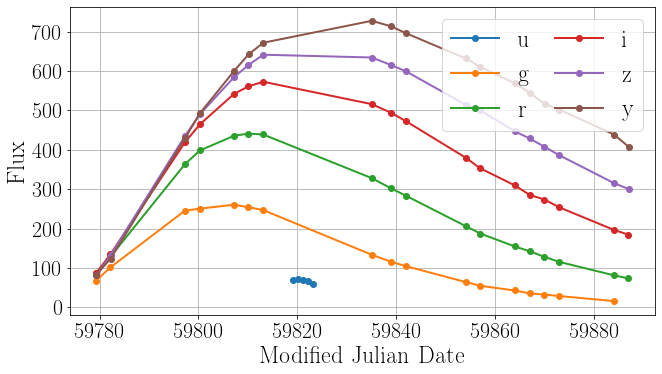

In [10]:
anobject = get_object(good_objects_df, 34299)

plot_light_curves(anobject)

In [11]:
from sklearn.model_selection import train_test_split
import gp_aug

anobject = get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = gp_aug.GaussianProcessesAugmentation(passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), n_obs=N_OBS)

t_aug_one = np.array(t_aug[:N_OBS])
flux_aug_list = flux_aug.reshape((N_PASSBANDS, N_OBS)).T
print(t_aug_one.shape, flux_aug_list.shape)

(500,) (500, 6)


In [12]:
from tqdm import tqdm_notebook

all_data = []
all_target_classes = []
for good_id in tqdm_notebook(object_ids):
    anobject = get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    model = gp_aug.GaussianProcessesAugmentation(passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), n_obs=N_OBS)

    data_array = flux_aug.reshape((N_PASSBANDS, N_OBS)).T
    all_data.append([data_array])
    
    true_class = int(anobject['class'].to_numpy()[0])

    all_target_classes.append(true_class)
    
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)


(2508, 1, 500, 6) (2508,)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.3,
                                                    random_state=179)

# normalize input
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10, 2))
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3824, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [16]:
import torch.optim as optim

net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [17]:
def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

In [18]:
epochs = np.arange(100)
for epoch in tqdm_notebook(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))

print('Finished Training')

[   10] error: 0.604
[   20] error: 0.406
[   30] error: 0.335
[   40] error: 0.191
[   50] error: 0.139
[   60] error: 0.121
[   70] error: 0.098
[   80] error: 0.094
[   90] error: 0.073
[  100] error: 0.072

Finished Training


In [19]:
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %d%%' % 
      (X_test_norm.shape[0], round(100 * test_accuracy)))
print('Train accuracy of the network on the %d train images: %d%%' % 
      (X_train_norm.shape[0], round(100 * train_accuracy)))

Test accuracy of the network on the 753 test images: 97%
Train accuracy of the network on the 1755 train images: 98%


In [20]:
y_test = []
y_probs = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        prob = test_outputs.item()
        if prob > 0.5:
            predicted = 1
        else:
            predicted = 0

        y_test.append(int(test_labels.item()))
        y_probs.append(prob)

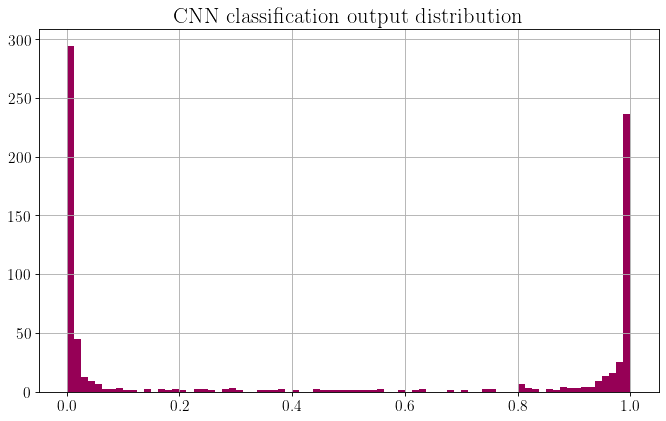

In [21]:
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("CNN classification output distribution", fontsize=20)
plt.xticks(fontsize=14, color="black")
plt.yticks(fontsize=14, color="black")
plt.grid(True)
plt.hist(y_probs, bins=80, color="xkcd:dark magenta")
plt.show()
fig.savefig("../pictures/cnn_output_hist.pdf")

Test ROC-AUC: 0.9864, test PR-AUC: 0.9709


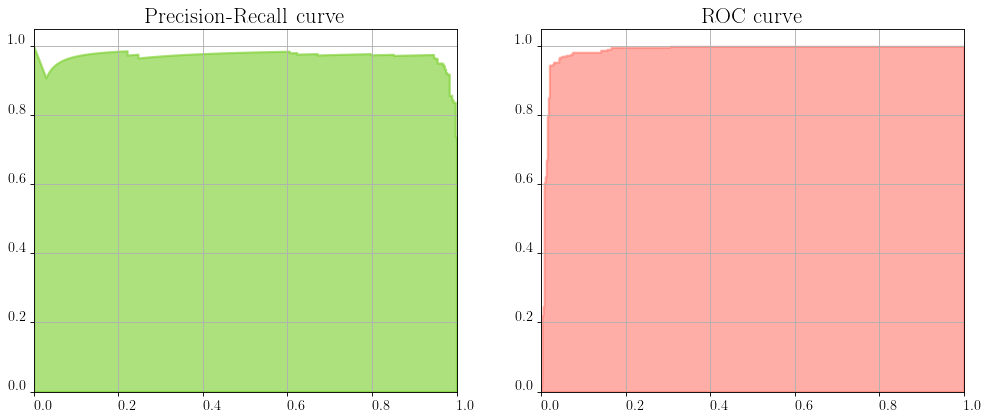

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

DPI = 80
SIZE_X, SIZE_Y = 15, 6

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(15, 6))
ax = fig.add_subplot(121)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("Precision-Recall curve", fontsize=20, color="black")
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("ROC curve", fontsize=20, color="black")
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:salmon", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fig.savefig("../pictures/CNN_pr_roc_curves.pdf", bbox_inches='tight', pad_inches=0.01)